# Extract Absence EEG data from dataset

Extract all the absence EEG data from the dataset, analyse and apply filters. Split into epochs/windows. Export for training.


In [75]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd;
%matplotlib qt

import math

import mne
from mne.filter import notch_filter

import csv

## Load Data From Dataset


In [3]:
# Set data location
DEV_DATA_FOLDER = "E:/edf/dev"

# Set absence data file names from absence_files.txt
ABSENCE_FILES_NAMES = []
with open(r"processed_data\absence\absence_files.txt", "r") as f:
    for i in f.readlines():
        ABSENCE_FILES_NAMES.append(DEV_DATA_FOLDER + i[:-1])


# Change index to change which absence seizure to load
def import_data(seizure_idx):
    raw = mne.io.read_raw_edf(ABSENCE_FILES_NAMES[seizure_idx])
    print(raw.load_data())
    return raw

In [4]:
seizure_idx = 0
raw = import_data(seizure_idx)

Extracting EDF parameters from E:\edf\dev\02_tcp_le\033\00003306\s001_2006_10_11\00003306_s001_t001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 356499  =      0.000 ...  1425.996 secs...
<RawEDF | 00003306_s001_t001.edf, 41 x 356500 (1426.0 s), ~111.6 MB, data loaded>


## Select n Channels


In [5]:
channels = [0, 1, 2, 3, 4]
excl_channels = raw.info["ch_names"][len(channels) :]
raw.drop_channels(
    excl_channels
)  # Drop channels in excl_channels, keep only channels in channels

Measurement date,"October 11, 2006 14:54:02 GMT"
Experimenter,Unknown
Participant,00003306
Digitized points,Not available
Good channels,5 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


## Analyse and Filter Data


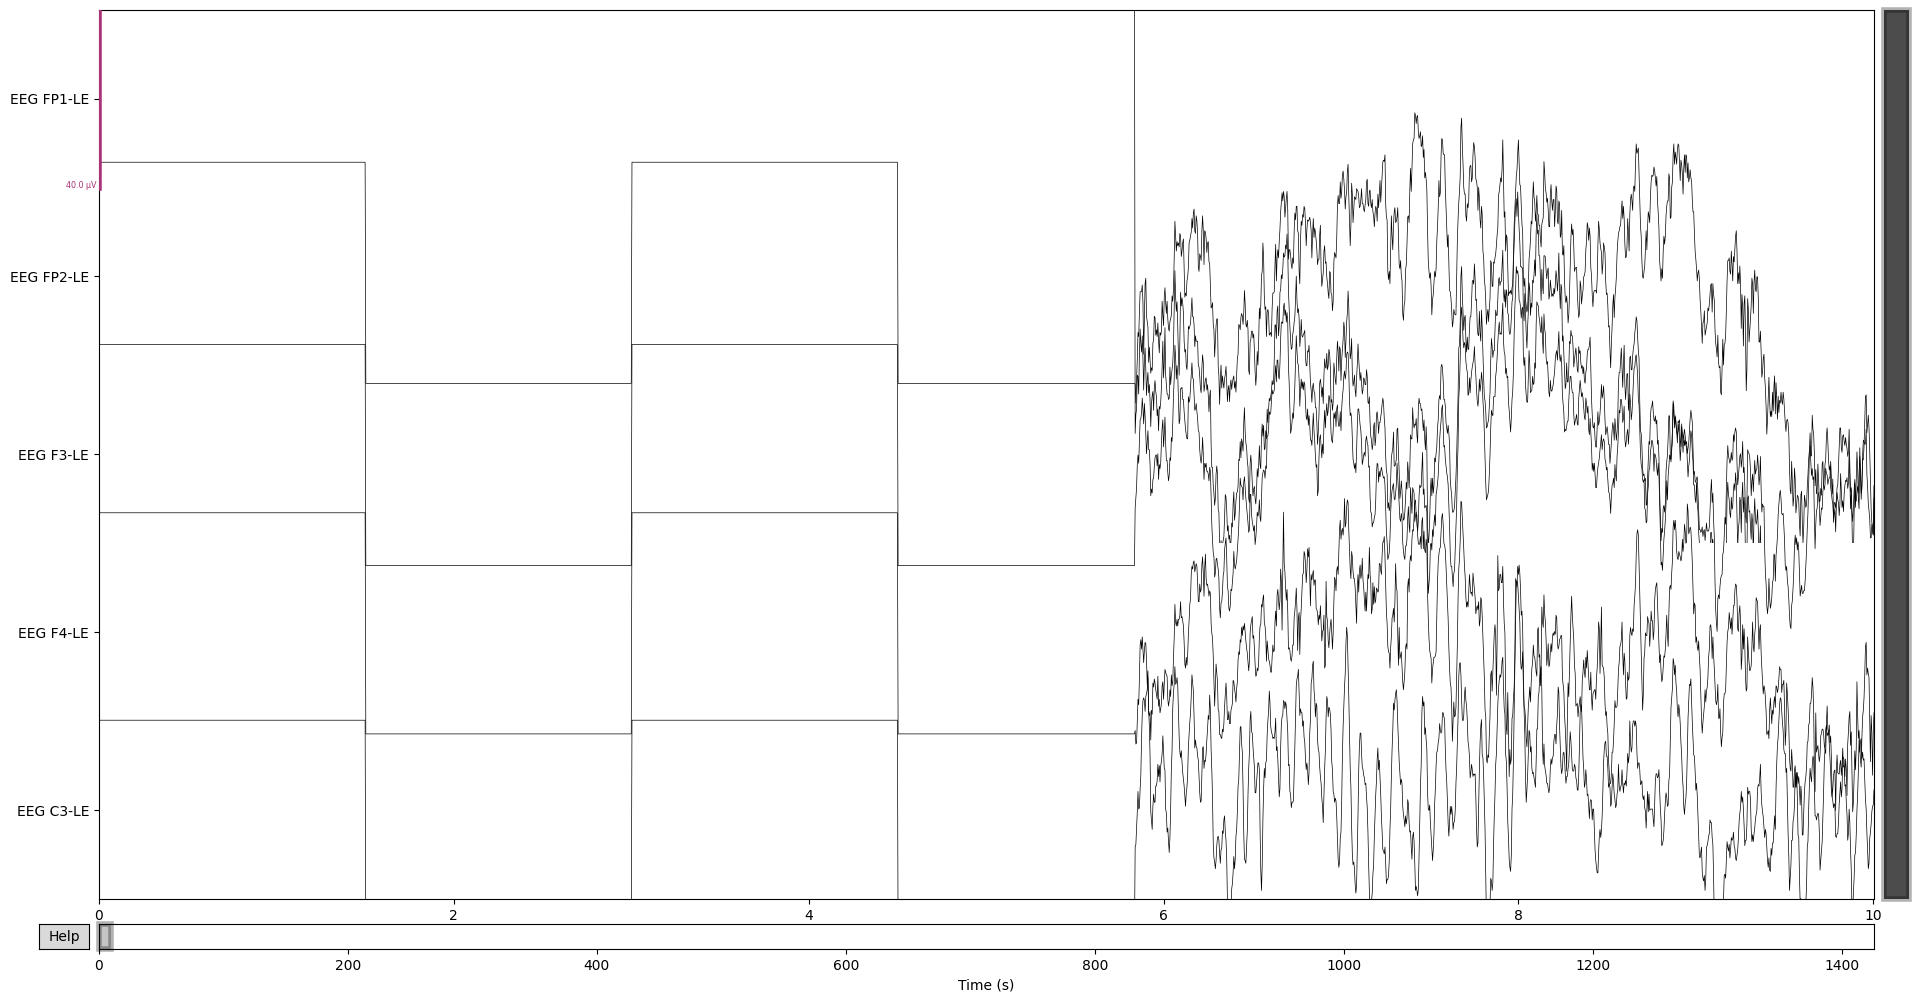

In [30]:
# Plot raw data
raw.plot()

Effective window size : 8.192 (s)


C:\Users\loicl\AppData\Local\Temp\ipykernel_20428\854838781.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()


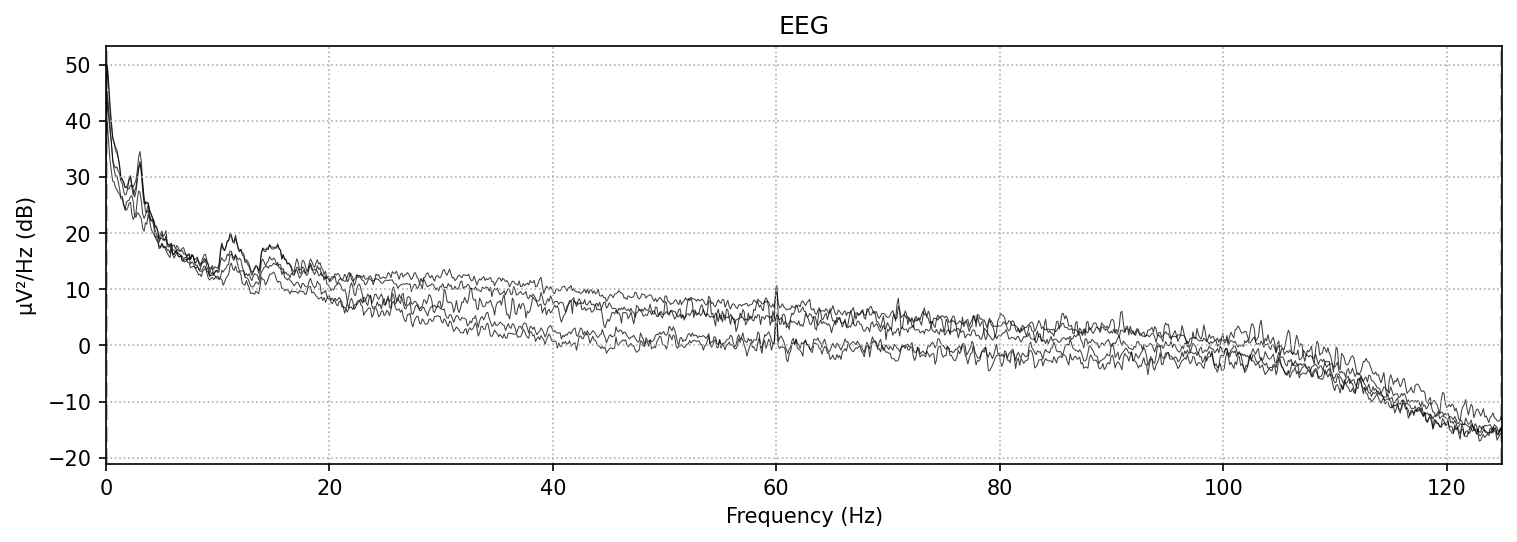

In [119]:
# Plot Power Spectral Density
raw.compute_psd().plot()

In [6]:
raw.notch_filter(60)  # 60 Hz notch filter
raw.filter(None, 90, fir_design="firwin")  # 90 Hz lowpass filter
# raw = mne.channels.combine_channels(raw, dict(new=[0, 1, 2, 3, 4]), method="mean")

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)



Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 90 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 90.00 Hz
- Upper transition bandwidth: 22.50 Hz (-6 dB cutoff frequency: 101.25 Hz)
- Filter length: 37 samples (0.148 s)



Measurement date,"October 11, 2006 14:54:02 GMT"
Experimenter,Unknown
Participant,00003306
Digitized points,Not available
Good channels,5 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,90.00 Hz


# Create and Apply Annotations


In [ ]:
def format_annotations(annotations_file):
    annotations_list = []
    with open(annotations_file, "r") as f:
        for i, v in enumerate(f.readlines()):
            if i >= 2:
                row = v.split(" ")
                row.remove(row[-1])
                annotations_list.append(row)
    return annotations_list

## Create Labels


In [7]:
def format_annotations(annotations_file):
    annotations_list = []
    with open(annotations_file, "r") as f:
        for i, v in enumerate(f.readlines()):
            if i >= 2:
                row = v.split(" ")
                row.remove(row[-1])
                annotations_list.append(row)
    return annotations_list

In [54]:
# Import annotations from annotation file
annotations_from_file = format_annotations(
    annotations_file=f"processed_data/absence/annotations/{seizure_idx+1}/annot.tse"
)
annotations_from_file

[['0.0000', '193.8440', 'bckg'],
 ['193.8440', '200.0440', 'absz'],
 ['200.0440', '287.8320', 'bckg'],
 ['287.8320', '296.5320', 'absz'],
 ['296.5320', '564.3040', 'bckg'],
 ['564.3040', '573.2149', 'absz'],
 ['573.2149', '1355.6120', 'bckg'],
 ['1355.6120', '1363.3120', 'absz'],
 ['1363.3120', '1426.0000', 'bckg']]

Collect beginning time and duration of each label


In [55]:
annotation_times = [[], [], []]

for i, v in enumerate(annotations_from_file):
    if v[2] == "bckg":
        annotation_times[0].append(float(v[0]))
        annotation_times[1].append(float(v[1]) - float(v[0]))
        annotation_times[2].append("0")
    elif v[2] == "absz":
        annotation_times[0].append(float(v[0]))
        annotation_times[1].append(float(v[1]) - float(v[0]))
        annotation_times[2].append("1")

Apply annotations to the data


Used Annotations descriptions: ['0', '1']


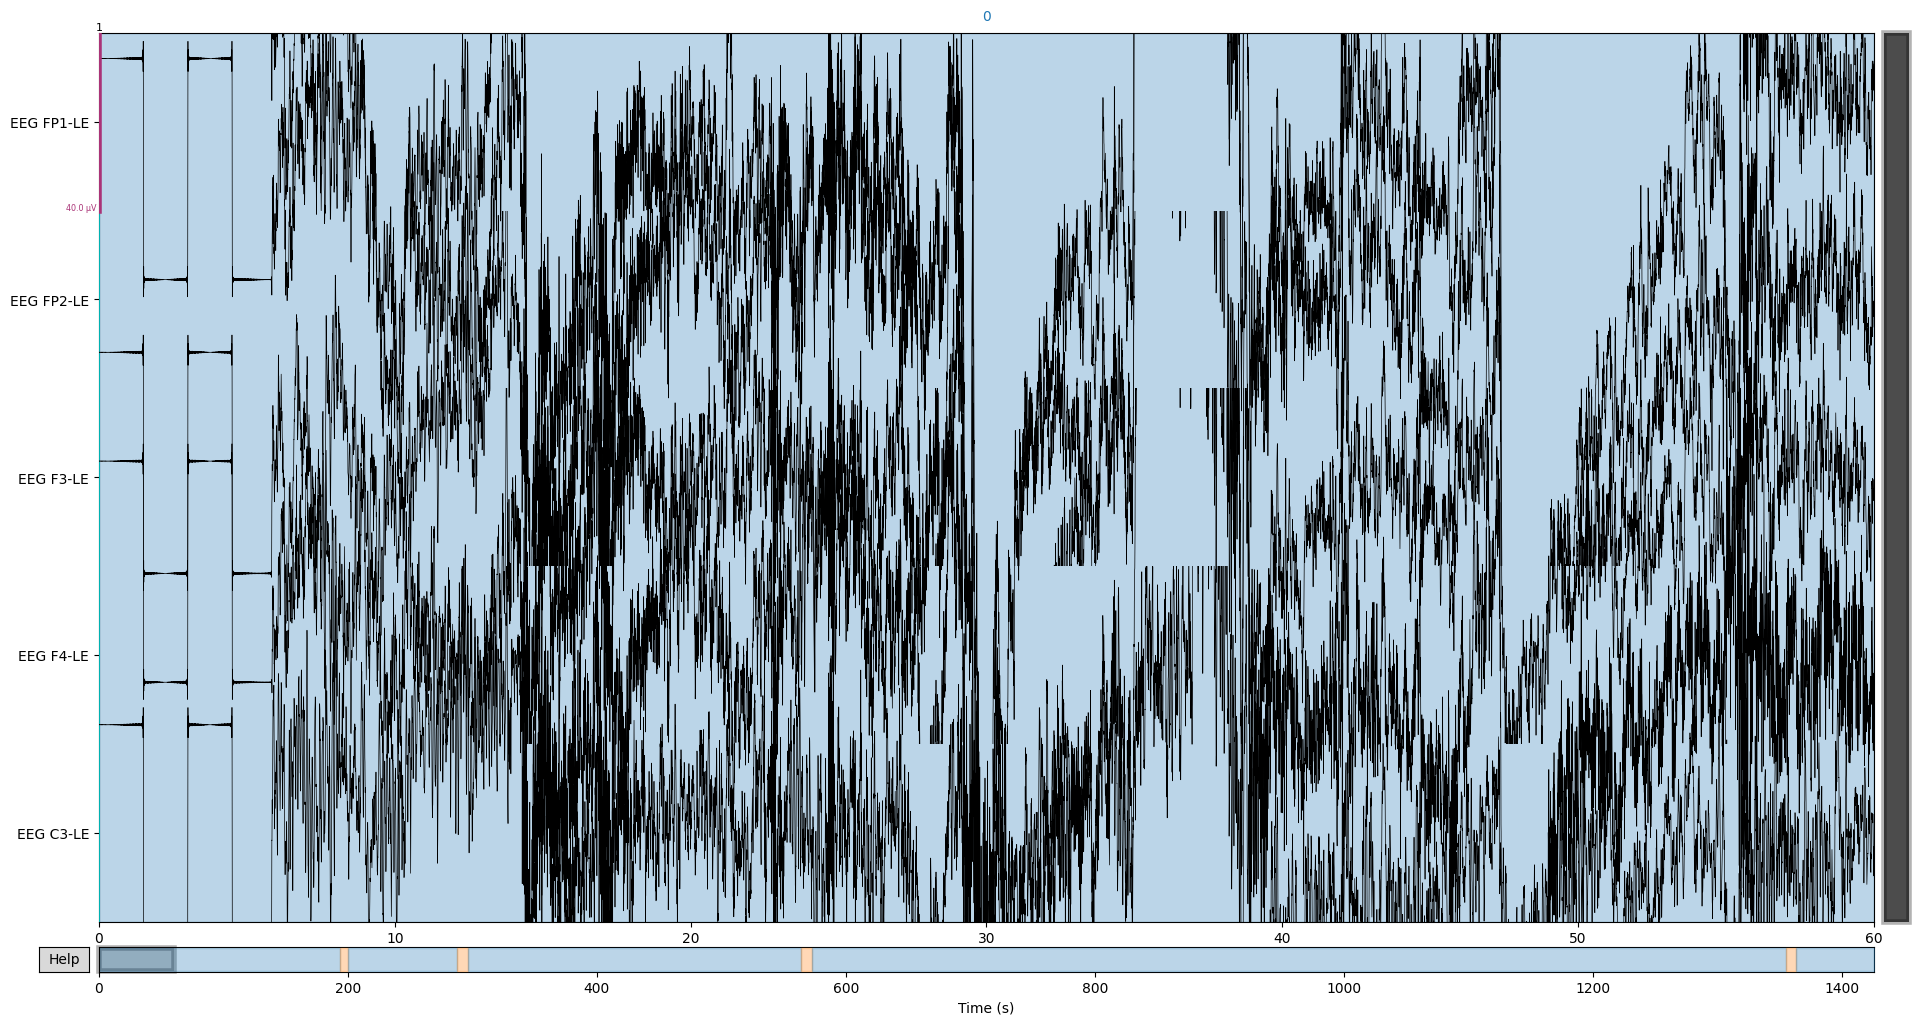

In [58]:
set_annotations = mne.Annotations(
    annotation_times[0], annotation_times[1], annotation_times[2]
)
raw.set_annotations(set_annotations)
events, event_id = mne.events_from_annotations(raw)

raw.plot(events=events, start=0, duration=60, color={"0": "blue", "1": "red"})

## Split into Epochs/Windows


In [64]:
epoch_duration = 4
epoch_overlap = 2
epochs = mne.make_fixed_length_epochs(
    raw, duration=epoch_duration, overlap=epoch_overlap
)

epochs_vector = epochs.get_data()

Not setting metadata
712 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 712 events and 1000 original time points ...
0 bad epochs dropped


Apply labels based on raw annotations


In [135]:
labels_list = [None] * len(epochs.events)
print(raw.annotations.description)
for i, v in enumerate(epochs.events):
    epoch_time_start = v[0] / 250
    epoch_time_end = epoch_time_start + epoch_duration
    epoch_range = list(range(math.floor(epoch_time_start), math.floor(epoch_time_end)))

    onset_list = []

    for j, k in enumerate(raw.annotations.onset):
        label_time_start = k
        label_time_end = k + (raw.annotations.duration[j])
        label_range = list(
            range(math.floor(label_time_start), math.floor(label_time_end))
        )

        count_in = 0
        count_out = 0

        for l in epoch_range:
            if l in label_range:
                count_in += 1
            else:
                count_out += 1

        onset_list.append(count_in / (count_in + count_out))

    for m, b in enumerate(onset_list):
        if b > 0.4 and (m % 2 != 0):
            max_inclusion_idx = m
            break
        if b == max(onset_list):
            max_inclusion_idx = m

    # print(onset_list)

    labels_list[i] = raw.annotations.description[max_inclusion_idx]

['0' '1' '0' '1' '0' '1' '0' '1' '0']


In [136]:
labels_list

['0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '1',
 '1',
 '1',
 '1',
 '1',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0',
 '0'

In [72]:
epochs.events

array([[     0,      0,      1],
       [   500,      0,      1],
       [  1000,      0,      1],
       ...,
       [354500,      0,      1],
       [355000,      0,      1],
       [355500,      0,      1]])

In [35]:
data, time = raw.get_data(return_times=True)

[0 0 1]
[500   0   1]
[1000    0    1]
[1500    0    1]
[2000    0    1]
[2500    0    1]
[3000    0    1]
[3500    0    1]
[4000    0    1]
[4500    0    1]
[5000    0    1]
[5500    0    1]
[6000    0    1]
[6500    0    1]
[7000    0    1]
[7500    0    1]
[8000    0    1]
[8500    0    1]
[9000    0    1]
[9500    0    1]
[10000     0     1]
[10500     0     1]
[11000     0     1]
[11500     0     1]
[12000     0     1]
[12500     0     1]
[13000     0     1]
[13500     0     1]
[14000     0     1]
[14500     0     1]
[15000     0     1]
[15500     0     1]
[16000     0     1]
[16500     0     1]
[17000     0     1]
[17500     0     1]
[18000     0     1]
[18500     0     1]
[19000     0     1]
[19500     0     1]
[20000     0     1]
[20500     0     1]
[21000     0     1]
[21500     0     1]
[22000     0     1]
[22500     0     1]
[23000     0     1]
[23500     0     1]
[24000     0     1]
[24500     0     1]
[25000     0     1]
[25500     0     1]
[26000     0     1]
[26500     0

## Save Data

Save data to npy binary files.


In [144]:
epochs_vector = epochs.get_data()

epochs_vector_filepath = f"processed_data/absence/{seizure_idx+1}/absence_data.npy"
epochs_labels_filepath = (
    f"processed_data/absence/{seizure_idx+1}/absence_data_labels.npy"
)

np.save(epochs_vector_filepath, epochs_vector)
np.save(epochs_labels_filepath, scaled_labels)

Using data from preloaded Raw for 621 events and 1000 original time points ...


In [31]:
# with open("processed_data/absence/epochs_files.csv", "w", newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(["data", "labels"])

In [131]:
with open("processed_data/absence/epochs_files.csv", "a", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([epochs_vector_filepath, epochs_labels_filepath])